# Dataset effects
- Some exploratory analysis: check completeness  
- Plot the individual dataset effects  
- TODO - Find datasets with significant individual effects  
- Plot the interaction effects  
- TODO - statistical tests for the interaction effects  

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt 
import json
import numpy as np
import pandas as pd 
import scipy
import seaborn as sns

from pathlib import Path

In [3]:
ft_tasks = ["cola", "sst2", "mrpc", "stsb", "qnli", "rte"]
probing_tasks = ["Length", "Depth", "TopConstituents", "BigramShift", "Tense", "SubjNumber", "ObjNumber", "OddManOut", "CoordinationInversion"]
experiments = [
    "100000", "010000", "001000", "000100", "000010", "000001", 
    "110000", "101000", "100100", "100010", "100001", "011000", 
    "010100", "010010", "010001", "001100", "001010", "001001",
    "000110", "000101", "000011", "101010", "101001", "100110",
    "100101", "011010", "011001", "010110", "010101", "111100",
    "110011", "001111", "111111"]
# 100000 means cola only. 110000 means cola & sst2, so on.

all_random_seeds = [1,10,42,123,1234]

In [4]:
def check_completeness(model="bert"):
    print ("Checking completness for model", model)
    for rs in all_random_seeds:
        for expid in range(len(experiments)+1):
            p = Path("../experiments", model, str(rs), str(expid), "test_results.json")
            if p.exists():
                ft_results = json.loads(p.read_text())
            elif expid > 0:
                print (f"expid={expid}, rs={rs} finetune results not found.")
            
            p = Path("../experiments", model, str(rs), str(expid), "probe_results.json")
            if p.exists():
                probing_results = json.loads(p.read_text())
            else:
                print (f"expid={expid}, rs={rs} probing results not found.")
    print("Done")

check_completeness("bert")
check_completeness("roberta")

Checking completness for model bert
expid=0, rs=1 probing results not found.
expid=0, rs=10 probing results not found.
expid=0, rs=42 probing results not found.
expid=0, rs=123 probing results not found.
expid=0, rs=1234 probing results not found.
Done
Checking completness for model roberta
expid=33, rs=1 finetune results not found.
expid=33, rs=1 probing results not found.
expid=33, rs=10 finetune results not found.
expid=33, rs=10 probing results not found.
expid=33, rs=42 finetune results not found.
expid=33, rs=42 probing results not found.
expid=33, rs=123 finetune results not found.
expid=33, rs=123 probing results not found.
expid=33, rs=1234 finetune results not found.
expid=33, rs=1234 probing results not found.
Done


In [9]:
def condition_to_experiment_id(condition=[]):
    if len(condition) == 0:
        return 0
    L = ["0"] * len(ft_tasks)
    for i, t in enumerate(ft_tasks):
        if t in condition:
            L[i] = "1"
    s = "".join(L)
    if s not in experiments:
        raise ValueError("Condition {} not in experiments".format(condition))
    else:
        return experiments.index(s)+1

def p_to_stars(p, bonferroni=1):
    if p < 0.001 / bonferroni:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return "not significant"
        
def get_probing_results(model, expid, rs, features, attr="acc"):
    """
    attr should be either "acc" or "devacc".
    Returns an np.array (len=len of probing tasks)
    """
    p = Path("../experiments", model, str(rs), str(expid), "probe_results.json")
    if not p.exists():
        raise ValueError("{} doesn't exist!".format(p))
    L = json.loads(p.read_text())
    return np.array([L[task][attr] for task in L if task in features])


def find_individual_effect(model="roberta", condition=[], target="cola", features=["Depth", "Tense"]):
    expid_start = condition_to_experiment_id(condition)
    expid_end = condition_to_experiment_id(condition + [target])
    print ("expid_start: {}, expid_end: {}".format(expid_start, expid_end))
    
    s_start = np.vstack([get_probing_results(model, expid_start, rs, features) for rs in all_random_seeds])
    s_end = np.vstack([get_probing_results(model, expid_end, rs, features) for rs in all_random_seeds])
    # each state is an np.array of shape [n_rs, n_probing_results]

    return s_start, s_end 

#find_individual_effect("roberta", ["cola"], target="sst2", features=["Depth", "Tense"])   

In [6]:
def read_results(model, rs, expid):
    p = Path("../experiments", model, str(rs), str(expid), "test_results.json")
    if p.exists():
        ft_results = json.loads(p.read_text())
    else:
        ft_results = None 
    p = Path("../experiments", model, str(rs), str(expid), "probe_results.json")
    if p.exists():
        probing_results = json.loads(p.read_text())
    else:
        probing_results = None 
    return ft_results, probing_results 

expid_start: 1, expid_end: 7
Dataset effect: {'Depth': (-1.8999999999999986, '*'), 'Tense': (-1.8399999999999892, '**')}


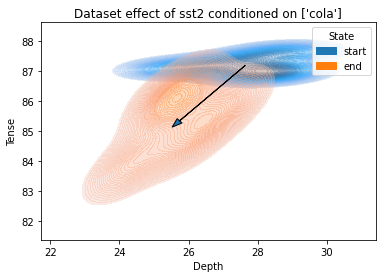

expid_start: 3, expid_end: 12
Dataset effect: {'Depth': (-1.8800000000000026, '*'), 'Tense': (-2.019999999999982, 'not significant')}


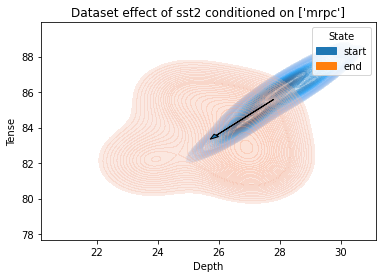

expid_start: 17, expid_end: 26
Dataset effect: {'Depth': (-2.260000000000005, '*'), 'Tense': (-2.4200000000000017, '*')}


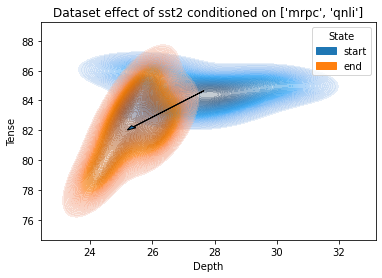

expid_start: 18, expid_end: 27
Dataset effect: {'Depth': (-0.5799999999999947, 'not significant'), 'Tense': (-1.2199999999999989, 'not significant')}


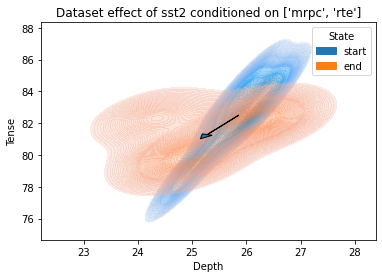

In [18]:
def compute_individual_effect(model, condition, target, features, plot=True):
    s_start, s_end = find_individual_effect(model, condition, target, features)
    
    ssc = s_start.mean(axis=0)  # state start centroid
    sec = s_end.mean(axis=0)
    diff = sec - ssc

    sigtest_results = []
    for i in range(len(features)):
        t, p = scipy.stats.ttest_ind(s_start[:,i], s_end[:,i])
        sigtest_results.append(p_to_stars(p))
    print("Dataset effect: {}".format({f:(d, sigtest) for (f,d, sigtest) in zip(features, diff, sigtest_results)}))

    if plot:
        plt.figure()
        # Scatterplot
        # plt.scatter(s_start[:, 0], s_start[:, 1], color="b")
        # plt.scatter(s_end[:, 0], s_end[:, 1], color="g")

        # KDE plot
        plotdata = {
            "State": ["start"] * len(s_start) + ["end"] * len(s_end)
        }
        for i, feat in enumerate(features):
            plotdata[feat] = np.concatenate([s_start[:, i], s_end[:, i]])
        plotdata = pd.DataFrame(plotdata)
        sns.kdeplot(data=plotdata, x=features[0], y=features[1], 
            hue="State", levels=100, fill=True, alpha=0.3)
    
        # Display an arrow showing the dataset effect
        plt.arrow(ssc[0], ssc[1], diff[0], diff[1], head_width=0.2)
    
        # Others
        plt.title("Dataset effect of {} conditioned on {}".format(target, condition))
        #plt.xlim([0, 100])
        #plt.ylim([0, 100])
        plt.show()

compute_individual_effect("roberta", ["cola"], target="sst2", features=["Depth", "Tense"])
compute_individual_effect("roberta", ["mrpc"], target="sst2", features=["Depth", "Tense"])
compute_individual_effect("roberta", ["mrpc", "qnli"], target="sst2", features=["Depth", "Tense"])
compute_individual_effect("roberta", ["mrpc", "rte"], target="sst2", features=["Depth", "Tense"])

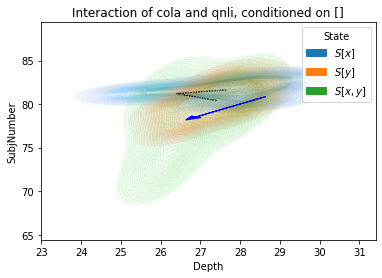

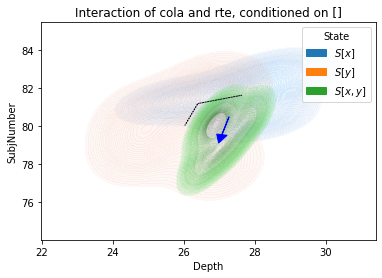

In [36]:
def compute_interaction_effect(model, condition, targetx, targety, features, plot=True):
    expid_base = condition_to_experiment_id(condition)
    expid_x = condition_to_experiment_id(condition + [targetx])
    expid_y = condition_to_experiment_id(condition + [targety])
    expid_xy = condition_to_experiment_id(condition + [targetx, targety])
    
    # Each s is np.array [n_rs, len(features)]
    s_base = np.vstack([get_probing_results(model, expid_base, rs, features) for rs in all_random_seeds])
    s_x = np.vstack([get_probing_results(model, expid_x, rs, features) for rs in all_random_seeds])
    s_y = np.vstack([get_probing_results(model, expid_y, rs, features) for rs in all_random_seeds])
    s_xy = np.vstack([get_probing_results(model, expid_xy, rs, features) for rs in all_random_seeds])

    c_base = s_base.mean(axis=0)
    c_x = s_x.mean(axis=0)
    c_y = s_y.mean(axis=0)
    c_xy = s_xy.mean(axis=0)
    eff_x = c_x - c_base 
    eff_y = c_y - c_base 
    eff_int = c_xy - c_x - c_y + c_base 
    pt = c_x + c_y - c_base

    #print("Dataset effect: {}".format({f:(d, sigtest) for (f,d, sigtest) in zip(features, diff, sigtest_results)}))

    if plot:
        plt.figure()

        # KDE 
        plotdata = {
            "State": ["$S[x]$"] * len(s_x) + ["$S[y]$"] * len(s_y) + ["$S[x,y]$"] * len(s_xy)
        }
        for i, feat in enumerate(features):
            plotdata[feat] = np.concatenate([s_x[:,i], s_y[:,i], s_xy[:,i]])
        plotdata = pd.DataFrame(plotdata)
        sns.kdeplot(data=plotdata, x=features[0], y=features[1],
            hue="State", levels=100, fill=True, alpha=0.1)

        # arrow
        plt.arrow(c_base[0], c_base[1], eff_x[0], eff_x[1], color="k", linestyle="dotted", label="$E(x)$")
        plt.arrow(c_base[0], c_base[1], eff_y[0], eff_y[1], color="k", linestyle="dotted", label="$E(y)$")
        plt.arrow(pt[0], pt[1], eff_int[0], eff_int[1], head_width=0.3, color="b", label="$Int(x,y)$")
        #plt.legend()

        plt.title("Interaction of {} and {}, conditioned on {}".format(targetx, targety, condition))
        plt.show()

compute_interaction_effect("roberta", [], targetx="cola", targety="qnli", features=["Depth", "SubjNumber"])
compute_interaction_effect("roberta", [], targetx="cola", targety="rte", features=["Depth", "SubjNumber"])